# Imports

In [1]:
import functools
import itertools
import re
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

from IPython.display import display, HTML

sys.path.append("../../src")
from llm_classification.utils import dataframe_utils
from llm_classification.datasets import give_me_some_credit

# Helper Functions

## `generate_model_eval_data`

In [2]:
def generate_model_eval_data(predictions_df):
    model_names = [
        name
        for name in predictions_df.columns.get_level_values(0).unique()
        if name != "target"
    ]
    
    y_true = predictions_df[("target", "SeriousDlqin2yrs")]
    for model_name in model_names:
        y_pred = predictions_df[(model_name, "pred")]
        
        y_prob = (
            predictions_df[(model_name, "pred_probs")]
            if (model_name, "pred_probs") in predictions_df.columns
            else None
        )
        
        yield model_name, (y_true, y_pred, y_prob)

## `compute_metrics`

In [3]:
def compute_metrics(y_true, y_pred, y_prob=None):
    metrics = {
        "accuracy": sklearn.metrics.accuracy_score(y_true, y_pred),
        "precision": sklearn.metrics.precision_score(y_true, y_pred, average="weighted"),
        "recall": sklearn.metrics.recall_score(y_true, y_pred, average="weighted"),
        "f1_score": sklearn.metrics.f1_score(y_true, y_pred, average="weighted"),
    }
    if y_prob is not None:
        try:
            metrics["roc_auc"] = sklearn.metrics.roc_auc_score(y_true, y_prob, multi_class="ovr")
        except Exception:
            metrics["roc_auc"] = np.nan
    else:
        metrics["roc_auc"] = np.nan
    return metrics

## `plot_confusion_matrix`

In [4]:
def plot_confusion_matrix(y_true, y_pred, model_name, color=None, ax=None):
    if color is not None:
        cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", color])
    else:
        cmap = plt.cm.Blues
        
    label_mapping = {
        0: "Negative",
        1: "Positive",
        -1: "Invalid Prediction",
        -2: "No Prediction Made"
    }

    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots(figsize=(6,6))
        
    labels_true = set(np.unique(y_true))
    labels_pred = set(np.unique(y_pred))
    labels = sorted(labels_true.union(labels_pred))
    class_names = list(map(
        lambda value: label_mapping.get(int(value),str(value)),
        labels
    ))
        
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    ax.matshow(cm, cmap=cmap, alpha=0.7)
    
    norm = cm / cm.max() if cm.max() > 0 else cm  # normalize to [0,1]
    for ii in range(cm.shape[0]):
        for jj in range(cm.shape[1]):
            color = "white" if norm[ii, jj] > 0.5 else "black"
            ax.text(jj, ii, cm[ii, jj], ha="center", va="center", color=color)
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    
    ax.xaxis.set_ticks_position("bottom")
    
    ax.set_xticklabels([str(label) for label in class_names], rotation=45, ha="right")
    ax.set_yticklabels([str(label) for label in class_names])
    
    # Optional: add some padding for x labels
    ax.tick_params(axis="x", which="major", pad=10)
    
    ax.set_title(f"{model_name}\nConfusion Matrix")
    
    if ax_is_none:
        plt.show()
        return fig

## `plot_roc_curve`

In [5]:
def plot_roc_curve(y_true, y_prob, model_name, color=None, ax=None):
    if y_prob is not None:
        ax_is_none = ax is None
        if ax_is_none:
            fig, ax = plt.subplots(figsize=(6,6))
        
        sklearn.metrics.RocCurveDisplay.from_predictions(
            y_true, y_prob, name=model_name, color=color, ax=ax
        )
        ax.set_title(f"{model_name}\nROC Curve")
        
        if ax_is_none:
            plt.show()
            return fig

## `plot_pr_curve`

In [6]:
def plot_pr_curve(y_true, y_prob, model_name, color=None, ax=None):
    if y_prob is not None:
        ax_is_none = ax is None
        if ax_is_none:
            fig, ax = plt.subplots(figsize=(6,6))
        
        ap = sklearn.metrics.average_precision_score(y_true, y_prob)
        sklearn.metrics.PrecisionRecallDisplay.from_predictions(
            y_true, y_prob, name=model_name, color=color, ax=ax
        )
        ax.set_title(f"{model_name}\nPrecision-Recall Curve")
        
        if ax_is_none:
            plt.show()
            return fig

## `plot_roc_comparison`

In [7]:
def plot_roc_comparison(predictions_df, save_results=False):
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_cycle = itertools.cycle(default_colors)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    for model_name, (y_true, y_pred, y_prob) in generate_model_eval_data(predictions_df):
        color = next(color_cycle)
        if y_prob is not None and np.all(~np.isnan(y_prob)):
            plot_roc_curve(y_true, y_prob, model_name, color=color, ax=ax)

    ax.set_title("ROC Curve Comparison")
    ax.legend()
    if save_results:
        figure_name = ax.get_title()
        safe_figure_name = re.sub(r"[^A-Za-z0-9_-]+", "-", figure_name)
        filename = f"{safe_figure_name}.png"
        give_me_some_credit.save_results_figure(fig, filename)
    plt.show()

## `plot_pr_comparison`

In [8]:
def plot_pr_comparison(predictions_df, save_results=False):
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_cycle = itertools.cycle(default_colors)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    for model_name, (y_true, y_pred, y_prob) in generate_model_eval_data(predictions_df):
        color = next(color_cycle)
        if y_prob is not None and np.all(~np.isnan(y_prob)):
            plot_pr_curve(y_true, y_prob, model_name, color=color, ax=ax)
    
    ax.set_title("Precision-Recall Curve Comparison")
    ax.legend()
    if save_results:
        figure_name = ax.get_title()
        safe_figure_name = re.sub(r"[^A-Za-z0-9_-]+", "-", figure_name)
        filename = f"{safe_figure_name}.png"
        give_me_some_credit.save_results_figure(fig, filename)
    plt.show()

## `plot_probability_histogram`

In [9]:
def plot_probability_histogram(y_prob, model_name, color=None, ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots()
        
    bins = np.linspace(0, 1, 101)
    ax.hist(y_prob, bins=bins, color=color, edgecolor="black", range=(0, 1))
    ax.set_xlim(0, 1)
    ax.set_title(f"{model_name}\nPredicted Probability Distribution")
    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")
    
    if ax_is_none:
        plt.show()

    return ax

## `save_subplots`

In [10]:
def save_figure(model_name, plot_name, plot_func, figsize):
    safe_model_name = re.sub(r"[^A-Za-z0-9_-]+", "-", model_name)
    safe_plot_name = re.sub(r"[^A-Za-z0-9_-]+", "-", plot_name)
    filename = f"{safe_model_name}_{safe_plot_name}.png"

    fig, ax = plt.subplots(figsize=figsize)
    plot_func(ax=ax)
    fig.tight_layout()
    give_me_some_credit.save_results_figure(fig, filename)
    plt.close(fig)

def save_figures(model_name, plotters, figsize=None):
    for plot_name, plot_func in plotters.items():
        save_figure(model_name, plot_name, plot_func, figsize)

## `run_model_evaluations`

In [11]:
def make_plotters(y_true, y_pred, y_prob, model_name, color):
    return {
        "Confusion Matrix": functools.partial(
            plot_confusion_matrix,
            y_true=y_true,
            y_pred=y_pred,
            model_name=model_name,
            color=color
        ),
        "Probability Histogram": functools.partial(
            plot_probability_histogram,
            y_prob=y_prob,
            model_name=model_name,
            color=color
        ),
        "ROC Curve": functools.partial(
            plot_roc_curve,
            y_true=y_true,
            y_prob=y_prob,
            model_name=model_name,
            color=color
        ),
        "Precision-Recall Curve": functools.partial(
            plot_pr_curve,
            y_true=y_true,
            y_prob=y_prob,
            model_name=model_name,
            color=color
        ),
    }

def run_model_evaluations(predictions_df, save_results=False):
    results = []
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_cycle = itertools.cycle(default_colors)

    for model_name, (y_true, y_pred, y_prob) in generate_model_eval_data(predictions_df):
        display(HTML(f"<h1>Evaluating {model_name}. . .</h1>"))
        y_pred = predictions_df[(model_name, "pred")]
        y_prob = predictions_df.get((model_name, "pred_probs"), None)
        y_prob = None if np.isnan(y_prob).any() else y_prob

        metrics = compute_metrics(y_true, y_pred, y_prob)
        results.append({"model": model_name, **metrics})

        color = next(color_cycle)
        
        plotters = make_plotters(y_true, y_pred, y_prob, model_name, color)
        
        if y_prob is not None:
            fig, axes = plt.subplots(
                2, 2, figsize=(12, 10),
                gridspec_kw={'height_ratios': [1, 1]}
            )
            plotters["Confusion Matrix"](ax=axes[0, 0])
            plotters["Probability Histogram"](ax=axes[0, 1])
            plotters["ROC Curve"](ax=axes[1, 0])
            plotters["Precision-Recall Curve"](ax=axes[1, 1])
        else:
            fig, ax = plt.subplots(figsize=(6, 6))
            ax_map["Confusion Matrix"](ax=ax)

        plt.tight_layout()
        plt.show()
        
        if save_results:
            save_figures(model_name, plotters)

    performance_df = pd.DataFrame(results).set_index("model")
    display(performance_df)
    
    if save_results:
        give_me_some_credit.save_results_dataframe(
            performance_df, "performance_results.csv"
        )

# Load the Dataset

This section loads the predictions into a DataFrame and displays its basic information.


In [12]:
training_df, validation_df = give_me_some_credit.load_training_validation_results()

ground_truth_df = give_me_some_credit.load_training_data(verbose=False)
training_df.insert(0, ("target", "SeriousDlqin2yrs"), ground_truth_df["SeriousDlqin2yrs"])
validation_df.insert(0, ("target", "SeriousDlqin2yrs"), ground_truth_df["SeriousDlqin2yrs"])

display(HTML(f"<h1>Training Predictions</h1>"))
dataframe_utils.print_dataframe_info(training_df)

display(HTML(f"<h1>Validation Predictions</h1>"))
dataframe_utils.print_dataframe_info(validation_df)

DataFrame Memory Usage: 7.32 MB


dtype   count  non_null  \
target                            SeriousDlqin2yrs    int64  120000    120000   
Logistic Regression               pred                int64  120000    120000   
                                  pred_probs        float64  120000    120000   
Random Forest                     pred                int64  120000    120000   
                                  pred_probs        float64  120000    120000   
Histogram-Based Gradient Boosting pred                int64  120000    120000   
                                  pred_probs        float64  120000    120000   

                                                    null_count      mean  \
target                            SeriousDlqin2yrs           0  0.066842   
Logistic Regression               pred                       0  0.248500   
                                  pred_probs                 0  0.413107   
Random Forest                     pred                       0  0.067300   
                                  pred_probs                 0  0.065981   
Histogram-Based Gradient Boosting pred                       0  0.021292   
                                  pred_probs                 0  0.066893   

                                                         std           min  \
target                            SeriousDlqin2yrs  0.249749  0.000000e+00   
Logistic Regression               pred              0.432145  0.000000e+00   
                                  pred_probs        0.152842  4.039935e-32   
Random Forest                     pred              0.250542  0.000000e+00   
                                  pred_probs        0.181611  0.000000e+00   
Histogram-Based Gradient Boosting pred              0.144355  0.000000e+00   
                                  pred_probs        0.116309  2.502051e-03   

                                                         25%       50%  \
target                            SeriousDlqin2yrs  0.000000  0.000000   
Logistic Regression               pred              0.000000  0.000000   
                                  pred_probs        0.299985  0.396708   
Random Forest                     pred              0.000000  0.000000   
                                  pred_probs        0.000000  0.010000   
Histogram-Based Gradient Boosting pred              0.000000  0.000000   
                                  pred_probs        0.009775  0.021093   

                                                         75%       max  
target                            SeriousDlqin2yrs  0.000000  1.000000  
Logistic Regression               pred              0.000000  1.000000  
                                  pred_probs        0.499273  1.000000  
Random Forest                     pred              0.000000  1.000000  
                                  pred_probs        0.030000  1.000000  
Histogram-Based Gradient Boosting pred              0.000000  1.000000  
                                  pred_probs        0.064913  0.874337

target Logistic Regression            Random Forest  \
       SeriousDlqin2yrs                pred pred_probs          pred   
Row ID                                                                 
1                     1                   1   0.756797             1   
2                     0                   0   0.464318             0   
3                     0                   1   0.707312             0   
5                     0                   0   0.209631             0   
6                     0                   0   0.249206             0   
...                 ...                 ...        ...           ...   
149996                0                   0   0.243774             0   
149997                0                   0   0.451480             0   
149998                0                   0   0.298296             0   
149999                0                   1   0.504252             0   
150000                0                   0   0.288816             0   

                  Histogram-Based Gradient Boosting             
       pred_probs                              pred pred_probs  
Row ID                                                          
1            0.71                                 0   0.342372  
2            0.03                                 0   0.089232  
3            0.10                                 0   0.320130  
5            0.08                                 0   0.124813  
6            0.01                                 0   0.008083  
...           ...                               ...        ...  
149996       0.00                                 0   0.004548  
149997       0.00                                 0   0.020155  
149998       0.00                                 0   0.016222  
149999       0.00                                 0   0.010798  
150000       0.00                                 0   0.020499  

[120000 rows x 7 columns]

DataFrame Memory Usage: 4.58 MB


dtype  count  non_null  \
target                            SeriousDlqin2yrs    int64  30000     30000   
Logistic Regression               pred                int64  30000     30000   
                                  pred_probs        float64  30000     30000   
Random Forest                     pred                int64  30000     30000   
                                  pred_probs        float64  30000     30000   
Histogram-Based Gradient Boosting pred                int64  30000     30000   
                                  pred_probs        float64  30000     30000   
google/flan-t5-small D0 Q0        pred                int64  30000     30000   
                                  pred_probs        float64  30000     30000   
                                  yes_prob          float64  30000     30000   
                                  no_prob           float64  30000     30000   
google/flan-t5-small D0 Q1        pred                int64  30000     30000   
                                  pred_probs        float64  30000     30000   
                                  yes_prob          float64  30000     30000   
                                  no_prob           float64  30000     30000   
google/flan-t5-small D0 Q2        pred                int64  30000     30000   
                                  pred_probs        float64  30000     30000   
                                  yes_prob          float64  30000     30000   
                                  no_prob           float64  30000     30000   

                                                    null_count      mean  \
target                            SeriousDlqin2yrs           0  0.066833   
Logistic Regression               pred                       0  0.247733   
                                  pred_probs                 0  0.412915   
Random Forest                     pred                       0  0.020667   
                                  pred_probs                 0  0.064798   
Histogram-Based Gradient Boosting pred                       0  0.022133   
                                  pred_probs                 0  0.068042   
google/flan-t5-small D0 Q0        pred                       0  0.950700   
                                  pred_probs                 0  0.519499   
                                  yes_prob                   0  0.262285   
                                  no_prob                    0  0.242842   
google/flan-t5-small D0 Q1        pred                       0  0.000000   
                                  pred_probs                 0  0.440603   
                                  yes_prob                   0  0.440451   
                                  no_prob                    0  0.559205   
google/flan-t5-small D0 Q2        pred                       0  0.000000   
                                  pred_probs                 0  0.417511   
                                  yes_prob                   0  0.416678   
                                  no_prob                    0  0.581328   

                                                         std           min  \
target                            SeriousDlqin2yrs  0.249737  0.000000e+00   
Logistic Regression               pred              0.431703  0.000000e+00   
                                  pred_probs        0.153277  7.048824e-17   
Random Forest                     pred              0.142268  0.000000e+00   
                                  pred_probs        0.120529  0.000000e+00   
Histogram-Based Gradient Boosting pred              0.147120  0.000000e+00   
                                  pred_probs        0.117631  2.563933e-03   
google/flan-t5-small D0 Q0        pred              0.216497  0.000000e+00   
                                  pred_probs        0.015647  4.781167e-01   
                                  yes_prob          0.019649  1.693913e-01   
                                  no_prob           0.021320  1.361183e-01

target Logistic Regression            Random Forest  \
       SeriousDlqin2yrs                pred pred_probs          pred   
Row ID                                                                 
4                     0                   1   0.518869             0   
12                    0                   0   0.413919             0   
14                    1                   1   0.947342             1   
24                    0                   0   0.476525             0   
25                    0                   0   0.340831             0   
...                 ...                 ...        ...           ...   
149984                0                   0   0.180238             0   
149985                0                   0   0.170122             0   
149987                0                   0   0.386821             0   
149992                0                   0   0.309497             0   
149993                0                   0   0.391706             0   

                  Histogram-Based Gradient Boosting             \
       pred_probs                              pred pred_probs   
Row ID                                                           
4            0.00                                 0   0.022168   
12           0.00                                 0   0.013772   
14           0.63                                 1   0.618585   
24           0.00                                 0   0.014112   
25           0.03                                 0   0.009455   
...           ...                               ...        ...   
149984       0.00                                 0   0.005129   
149985       0.00                                 0   0.005574   
149987       0.03                                 0   0.025807   
149992       0.00                                 0   0.012891   
149993       0.01                                 0   0.063988   

       google/flan-t5-small D0 Q0                                 \
                             pred pred_probs  yes_prob   no_prob   
Row ID                                                             
4                               1   0.523325  0.248806  0.226628   
12                              1   0.532325  0.266791  0.234390   
14                              1   0.583578  0.224461  0.160168   
24                              1   0.501114  0.261580  0.260417   
25                              1   0.513826  0.257440  0.243585   
...                           ...        ...       ...       ...   
149984                          1   0.511567  0.266742  0.254680   
149985                          1   0.507404  0.279580  0.271420   
149987                          1   0.529707  0.288262  0.255930   
149992                          1   0.522047  0.260023  0.238060   
149993                          1   0.521922  0.275122  0.252010   

       google/flan-t5-small D0 Q1                                 \
                             pred pred_probs  yes_prob   no_prob   
Row ID                                                             
4                               0   0.451797  0.451643  0.548016   
12                              0   0.442041  0.441889  0.557768   
14                              0   0.459329  0.459175  0.540490   
24                              0   0.440193  0.440042  0.559614   
25                              0   0.444707  0.444551  0.555098   
...                           ...        ...       ...       ...   
149984                          0   0.446341  0.446193  0.553476   
149985                          0   0.435533  0.435390  0.564281   
149987                          0   0.454778  0.454623  0.545038   
149992                          0   0.443931  0.443778  0.555879   
149993                          0   0.432476  0.432323  0.567323   

       google/flan-t5-small D0 Q2                                 
                             pred pred_probs  yes_prob   no_prob  
Row ID                                     

# Validation Results

This section presents the evaluation of all models on the validation dataset. It includes detailed performance metrics, visualizations, and comparative analyses to assess how well each model generalizes to unseen data.


## Model Evaluation Summary

This section uses the `run_model_evaluations` function to assess each model’s predictive performance on the validation set. For every model, we calculate the following metrics:

- Accuracy  
- Precision  
- Recall  
- F1 Score  
- ROC AUC  
- Average Precision (AP)

We visualize performance using a confusion matrix, alongside side-by-side ROC and Precision-Recall (PR) curves. These plots provide complementary views of model classification quality. The results are compiled into a table for easy side-by-side comparison across models.


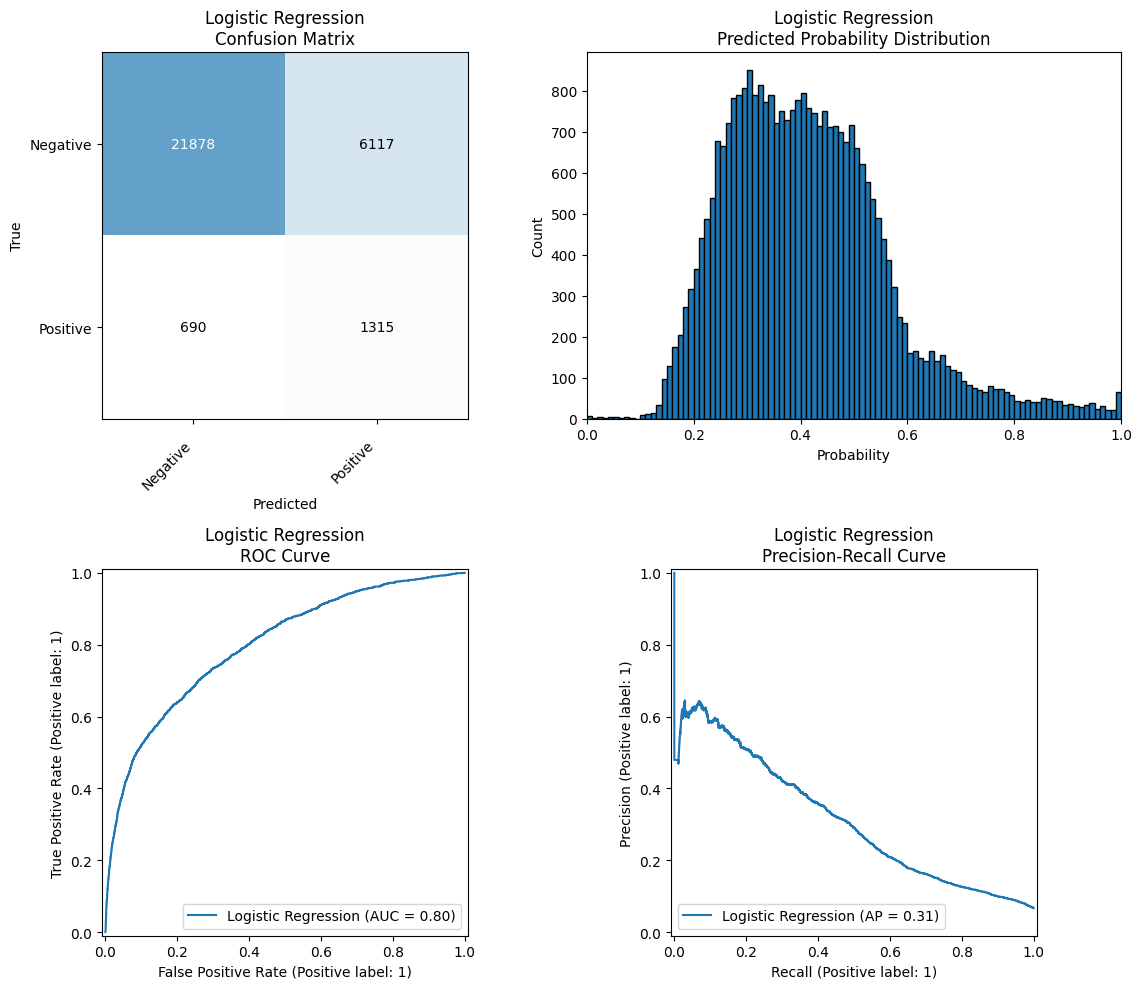

2025-09-26 15:56:08,245 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Logistic-Regression_Confusion-Matrix.png
2025-09-26 15:56:08,488 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Logistic-Regression_Probability-Histogram.png
2025-09-26 15:56:08,660 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Logistic-Regression_ROC-Curve.png
2025-09-26 15:56:08,833 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Logistic-Regression_Precision-Recall-Curve.png


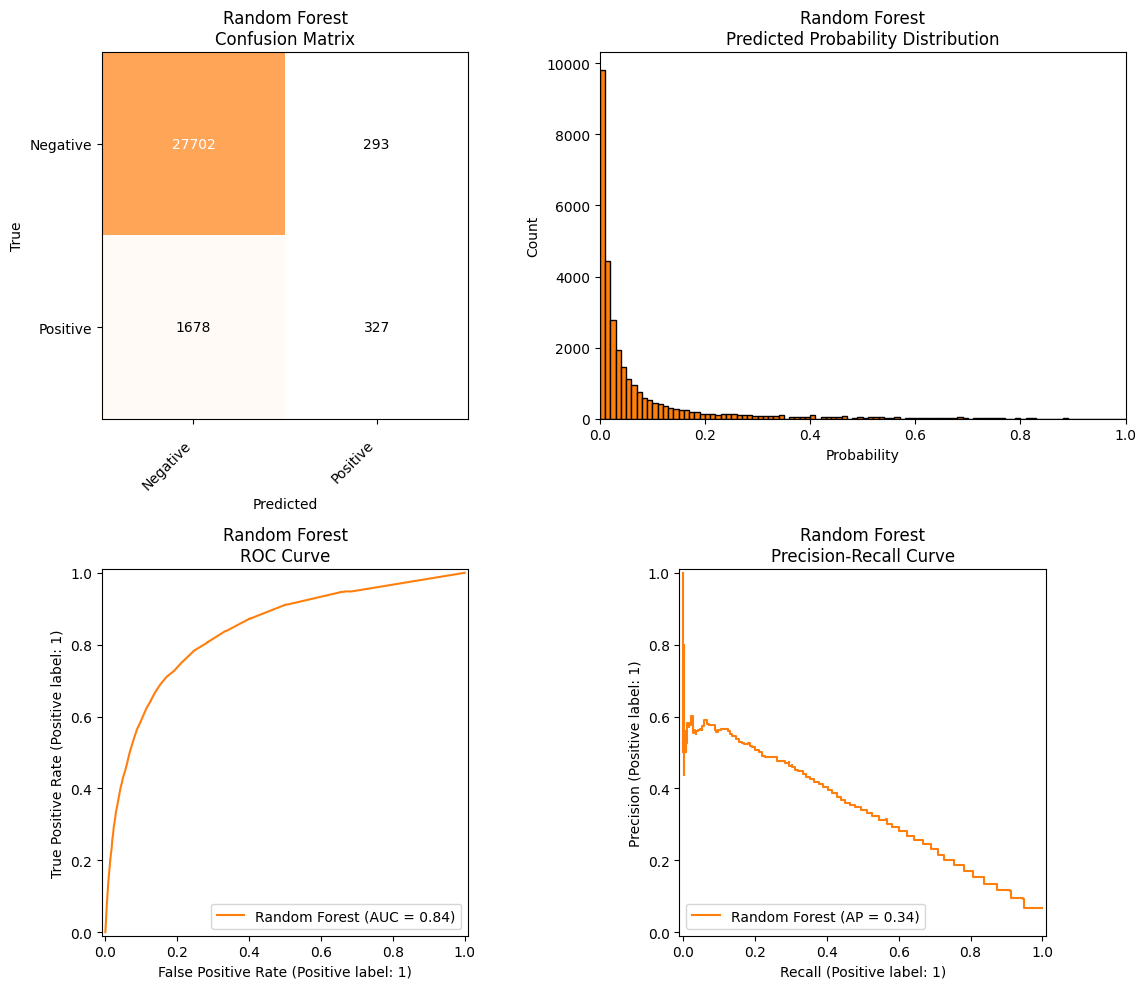

2025-09-26 15:56:09,630 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Random-Forest_Confusion-Matrix.png
2025-09-26 15:56:09,853 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Random-Forest_Probability-Histogram.png
2025-09-26 15:56:10,019 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Random-Forest_ROC-Curve.png
2025-09-26 15:56:10,183 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Random-Forest_Precision-Recall-Curve.png


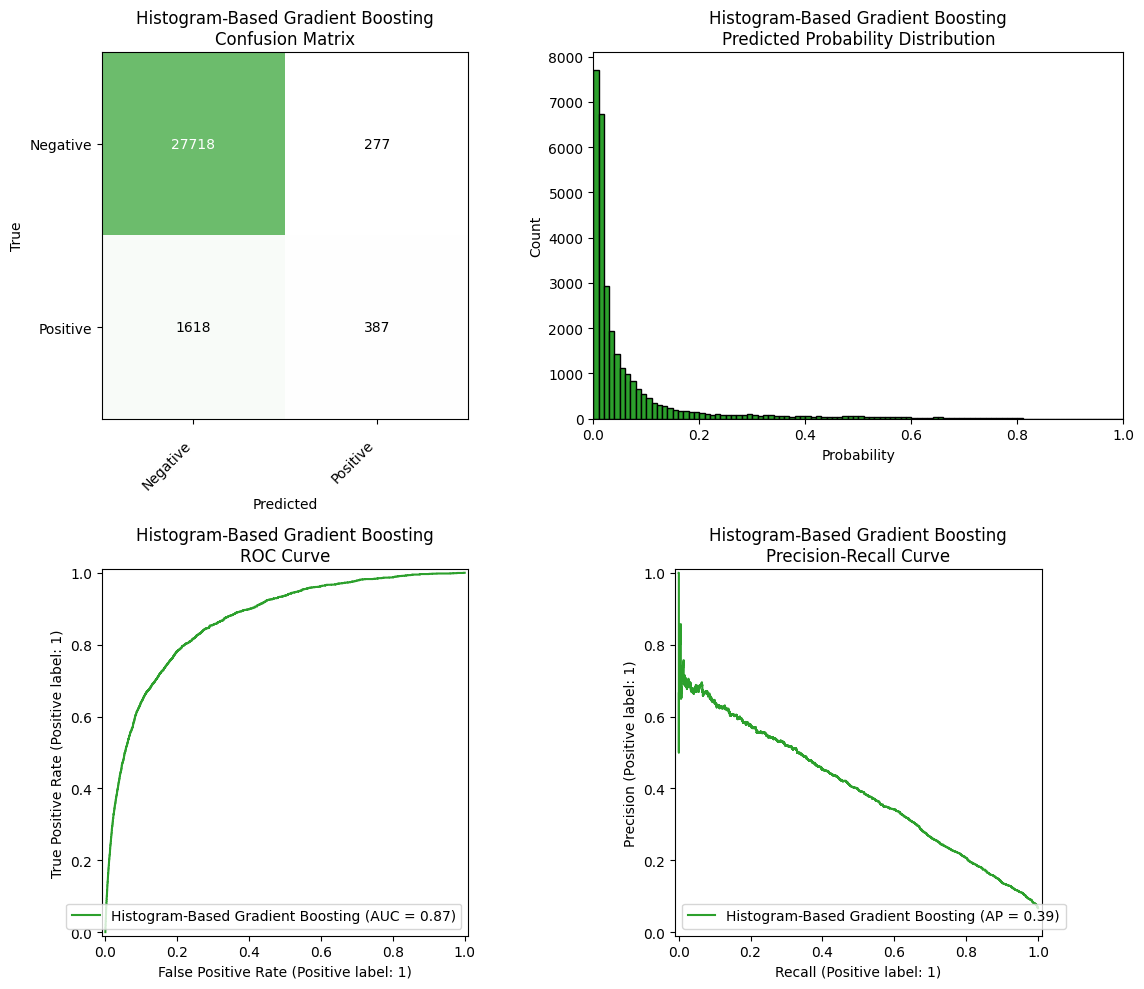

2025-09-26 15:56:11,013 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Histogram-Based-Gradient-Boosting_Confusion-Matrix.png
2025-09-26 15:56:11,339 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Histogram-Based-Gradient-Boosting_Probability-Histogram.png
2025-09-26 15:56:11,498 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Histogram-Based-Gradient-Boosting_ROC-Curve.png
2025-09-26 15:56:11,682 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Histogram-Based-Gradient-Boosting_Precision-Recall-Curve.png


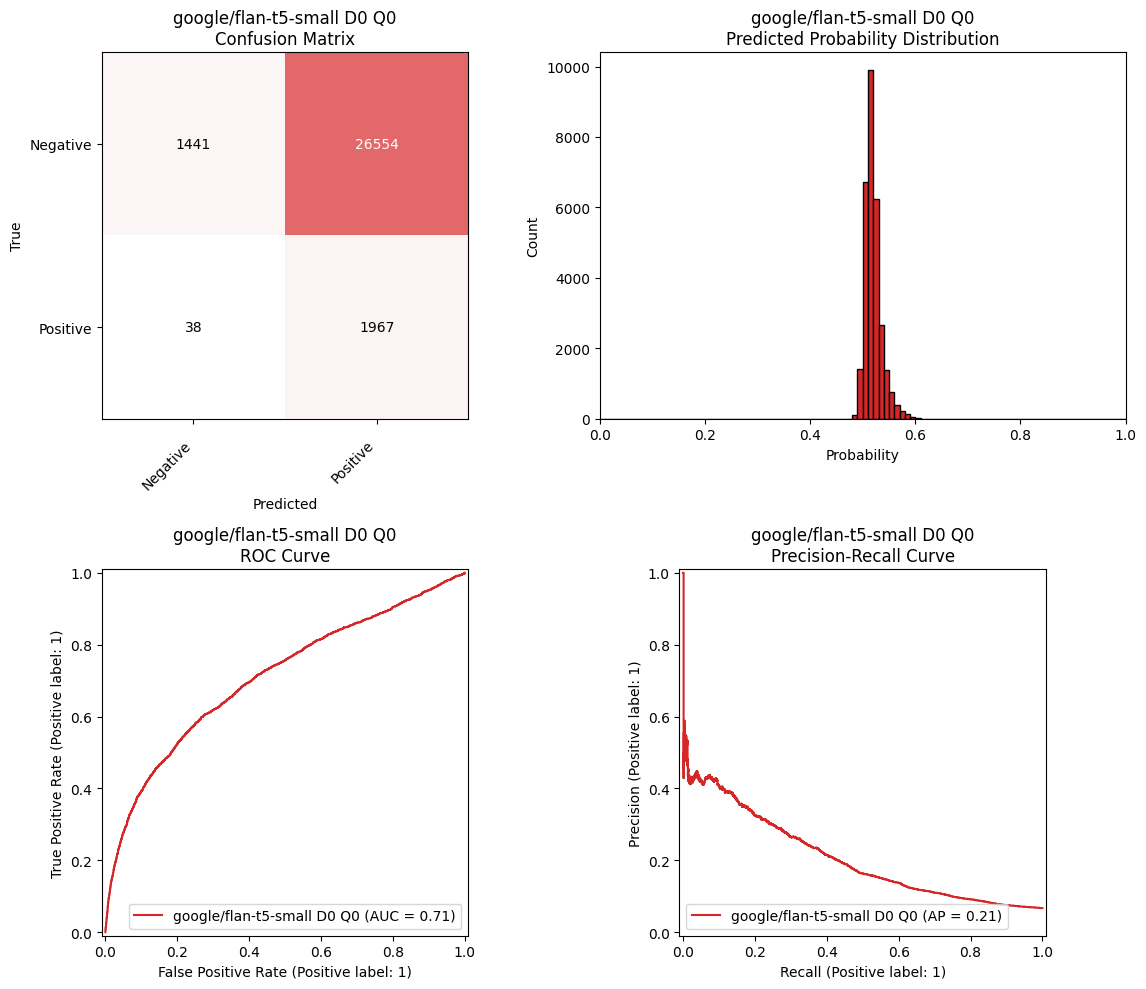

2025-09-26 15:56:12,469 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q0_Confusion-Matrix.png
2025-09-26 15:56:12,691 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q0_Probability-Histogram.png
2025-09-26 15:56:12,854 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q0_ROC-Curve.png
2025-09-26 15:56:13,031 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q0_Precision-Recall-Curve.png


/Users/jagraves21/venv/unmixing/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


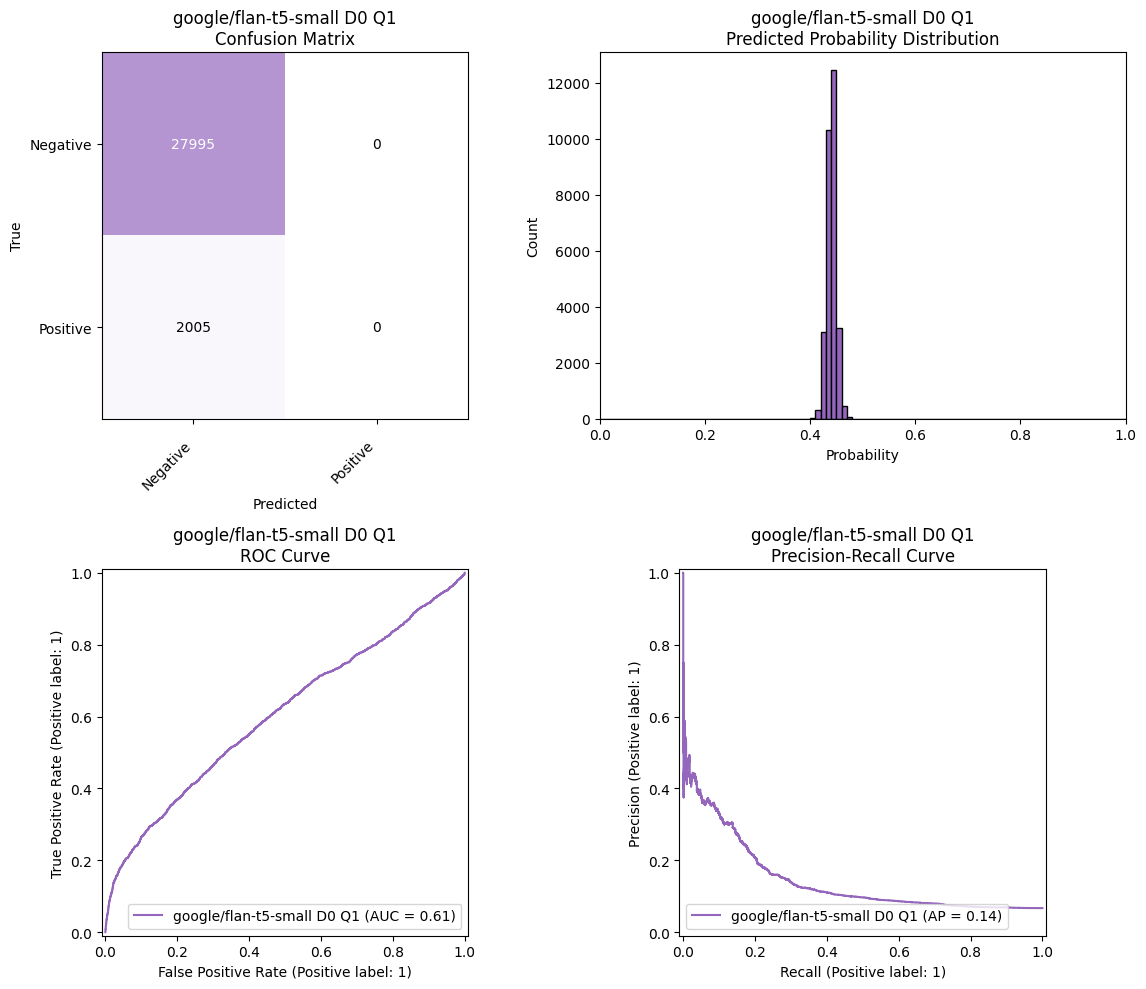

2025-09-26 15:56:13,819 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q1_Confusion-Matrix.png
2025-09-26 15:56:14,044 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q1_Probability-Histogram.png
2025-09-26 15:56:14,207 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q1_ROC-Curve.png
2025-09-26 15:56:14,387 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q1_Precision-Recall-Curve.png


/Users/jagraves21/venv/unmixing/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


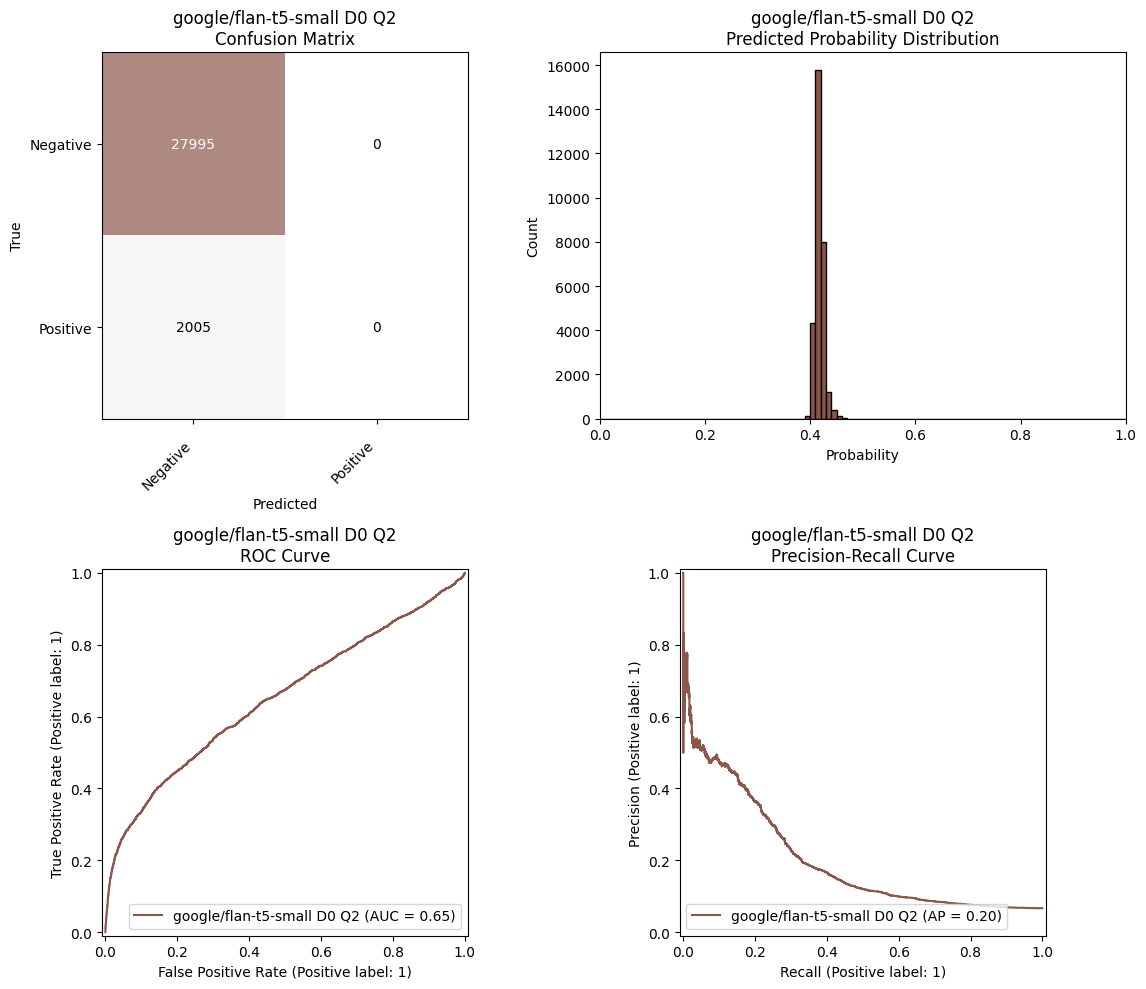

2025-09-26 15:56:15,296 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q2_Confusion-Matrix.png
2025-09-26 15:56:15,535 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q2_Probability-Histogram.png
2025-09-26 15:56:15,694 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q2_ROC-Curve.png
2025-09-26 15:56:15,869 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/google-flan-t5-small-D0-Q2_Precision-Recall-Curve.png


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Logistic Regression,0.773100,0.916461,0.773100,0.826166,0.798861
Random Forest,0.934300,0.915119,0.934300,0.917761,0.838298
Histogram-Based Gradient Boosting,0.936833,0.920651,0.936833,0.921703,0.867324
google/flan-t5-small D0 Q0,0.113600,0.913800,0.113600,0.099859,0.708933
google/flan-t5-small D0 Q1,0.933167,0.870800,0.933167,0.900905,0.606003
google/flan-t5-small D0 Q2,0.933167,0.870800,0.933167,0.900905,0.650841


2025-09-26 15:56:15,882 - INFO - Saved DataFrame to results directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/results/performance_results.csv


In [13]:
run_model_evaluations(validation_df, save_results=True)

## ROC AUC Comparison Plots

This code plots ROC curves for all models on the same axes, making it easy to compare their true positive and false positive trade-offs. Higher ROC AUC values indicate better overall classification performance.


2025-09-26 15:56:16,189 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/ROC-Curve-Comparison.png


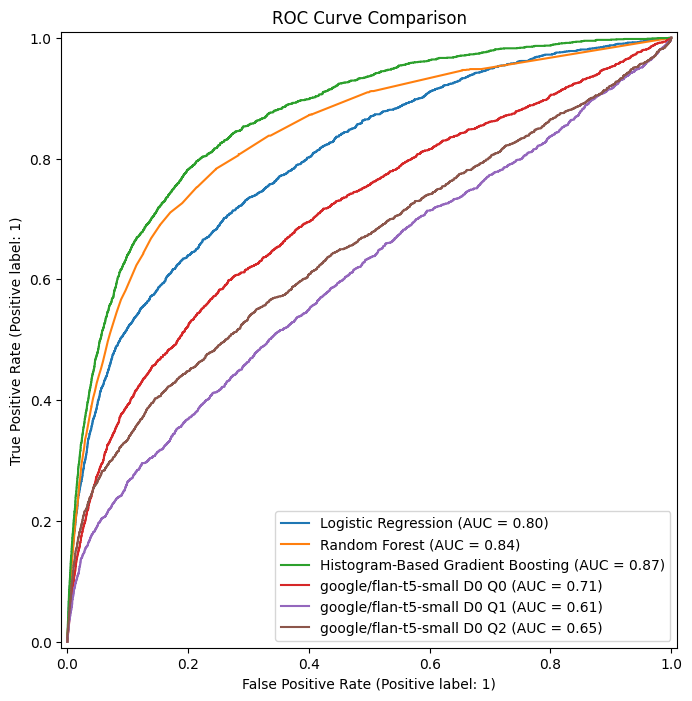

In [14]:
plot_roc_comparison(validation_df, save_results=True)

## Precision-Recall (PR) Curve Comparison

This code plots Precision-Recall curves for all models on the same axes, allowing comparison of their precision and recall trade-offs at different classification thresholds. Higher Average Precision (AP) values indicate better ability to identify positive cases with fewer false positives.


2025-09-26 15:56:16,886 - INFO - Saved figure to figures directory: /Users/rina/llm-classification/data/GiveMeSomeCredit/figures/Precision-Recall-Curve-Comparison.png


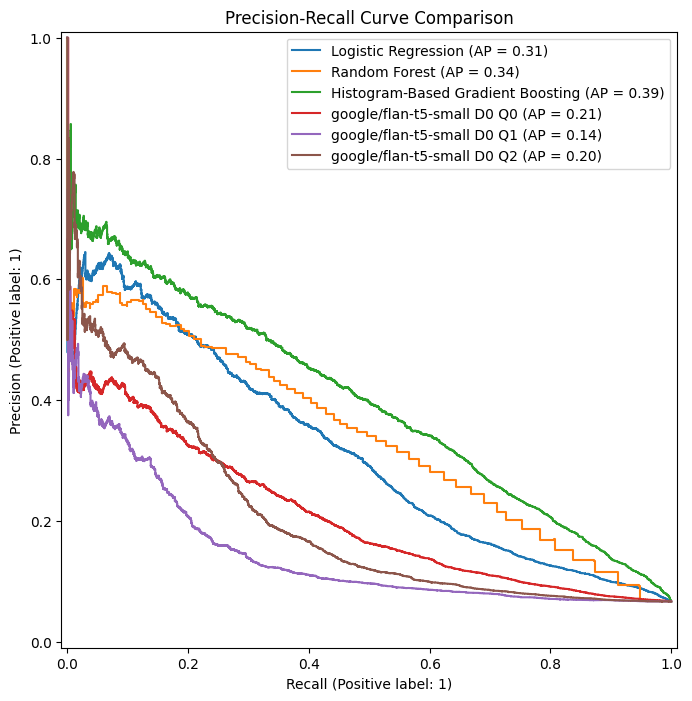

In [15]:
plot_pr_comparison(validation_df, save_results=True)